# Programing *in silico* microbiomes

## Introduction 

The microbial abundance series of the metagenomic data strognly resembles us to the trajectories that a random walk may generate. This suggest using Stochastic Differential Equations (SDEs) to model the experimental data.

In this tutorial we will learn how to simulate *in silico* microbiomes by means of the Stochastic Lotka-Volterra model including an environmental filter term:

$$ \dot{x}_i=\frac{x_i}{\tau_i}\left(1-\frac{x_i}{K_i}+\sum^S_{i\neq j}c_{ij}x_j\right)+\sqrt{\frac{\sigma_i}{\tau_i}}x_i\xi_i (t) $$

where: 

* $S$: total number of species
* $\tau_i$: is the time scale of basal population growth
* $K_i$: is the maximum carrying capacity
* $(c_{ij})=\hat{C}$: is the Lotka-Volterra interaction matrix 
* $\xi_i$: is a zero-mean Gaussian noise with correlations $\langle \xi_i (t) \xi_j (t^\prime ) \rangle =s_{ij} \delta(t-t^\prime)$ --aimed to describe environmental fluctuations--
* $s_{ij}$ describes the resource preference of the pair of species $(i,j)$, thus if $s_{ij}>0$ species have preference for the same resources/environmental conditions, whereas they have opposite preference if $s_{ij}<0$.
* $\sigma_i$: is the strength of the environmental fluctuations experimented by each specie. 

## Getting started: the Stochastic Logistic Model (SLM)

Let us start by the simplest form of Eq. , when all species are independent and thus the interaction matrix are diagonal: $c_{ij}=0 \hspace{1mm} \forall i\neq j$ and $s_{ij}=\delta_{ij}$, where $\delta_{ij}$ is the Kronecker-delta. 

$$ \dot{x}_i=\frac{x_i}{\tau_i}\left(1-\frac{x_i}{K_i}\right)+\sqrt{\frac{\sigma_i}{\tau_i}}x_i\xi_i (t) $$

To integrate this equation we will use the well known Euler-Maruyama method: 

$$ x(t_j)=x(t_{j-1})+h\frac{x(t_{j-1})}{\tau_i}[1-x_i(t_{j-1})/K_i]+\sqrt{\frac{h\sigma_i}{\tau_i}}x(t_{j-1})w_i $$

where:

* $i=1,\dots,S$ runs over spcies
* $h$: is the integratio step, $h=\frac{t_f-t_i}{N_t}$
* $j$: runs over time: $t_j=t_i+j\cdot h$
* $w_i$ is a random variable normally distributed: $\sim\mathcal{N}(0,1)$

The order of convergence of this algorithm over the trajectories is $O(h^{3/2})$

In [2]:
def StochasticLogisticModel (K,tau,sigmaNoise,muNoise,nSim,timeList,abundanceStart,S):
    
    """
    Stochastic Logistic equation (SLM) solution by Euler-Maruyama method;
    
    INPUT
    - K (float): carrying capacitities;
    - tau (float): intrinsic growth time;
    - sigmaNoise (float): variance of the Gaussian noise;
    - muNoise (float): mean value of the Gaussian noise;
    - nSim (float): number of simulation;
    - timeList (1d array): list of T time instants;
    - abundanceStart (float): initial abundance;
    - S (float): number of species;
    
    OUTPUT
    - longitudinal (T x S array): abundance of the species j at time i;
    - crossSectional (S x nSim array): abundance of the k trajectory at the last time for the j trajectory;
    """
    
    #initial state
    x0 = np.full(S,abundanceStart)

    #simulation loop

    abundanceMat = np.zeros((timeList.size,S,nSim),dtype=float)
    
    dt = round((timeList[-1]-timeList[0])/(len(timeList)),2)
    
    for sim in range(nSim):
        
        abundanceMat[0,:,sim] = x0
        
        #time loop
        for t in range(1,timeList.size):

            #dynamics
            x = abundanceMat[t-1,:,sim]
            noise = muNoise+np.sqrt(sigmaNoise/tau)*np.random.normal(0,1,size=(S)) #Gaussian noise
            xt = x+x*dt/tau-x**2/(tau*K)*dt+(noise*x*mt.sqrt(dt)) #equation
        
            abundanceMat[t,:,sim]=np.round(xt,5)
    
    longitudinal = abundanceMat[:,:,0]
    crossSectional = abundanceMat[-1,:,:]
    
    return([longitudinal,crossSectional])

Let's start with the simple case of a single species: $S=1$ and see the result. In the following code I fix the parameters of the simulation:

In [3]:
##################
#    LIBRARIES   #
##################
import numpy as np
import math as mt
from matplotlib import pyplot as plt

#############################
#   SIMULATION PARAMETERS   #
#############################

S=1 #total number of species
tau=0.1  #time-scale of basal population growth
K=1 #maximum carrying capacity
muNoise=0 #mean of the environmental fluctuations
sigmaNoise=0.05 #strength of the environmental fluctuations
nSim = 1 #total number of simulations
abundanceStart=0.1 

#time
tStart = 0
tEnd = 2
dt = 0.01
timeList = np.arange(tStart,tEnd+dt,dt)

Then we can call the function we created before *StochasticLogisticModel* to run a simulation

Text(0.5, 1.0, 'StochasticLogisticModel')

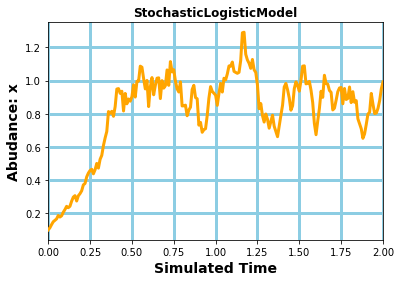

In [4]:
#Run simulations
[longitudinal,crossSectional]=StochasticLogisticModel (K,tau,sigmaNoise,muNoise,nSim,timeList,abundanceStart,S)

#########################
#          PLOT         #
#########################

plt.plot(timeList,longitudinal,color="orange",linewidth=3,zorder=3)
plt.xlim(0,2)
plt.grid("on",color="#8ccde3",linewidth=3.0,zorder=0) #add a blue grid
plt.xlabel("Simulated Time",fontweight='bold',fontsize=14) #add x-label
plt.ylabel("Abudance: x",fontweight='bold',fontsize=14) #add y-label
plt.title("StochasticLogisticModel",fontweight='bold') #set title

### Time to reach the steady state

 The solution of the deterministic part of the Logistic Model is given by:

$$ x(t)=\frac{x_0e^{t/\tau}}{1+\left(\frac{x_0}{K}\left[e^{t/\tau}-1\right]\right)} $$

where $x_0$. From this equation we can ask how long it takes for the system to approach the asymptote $x=K$ as close as we like, i.e., we define $t^\star$ the time at which the abundance $x(t^\star)=K-\epsilon$ (where $\epsilon$ is the distance to the asymptote):

$$ t^\star=\tau\cdot log\left[\frac{(K-\epsilon)}{\epsilon}\left(\frac{K}{x_0}-1\right)\right] $$

Text(1.25, 1.5, 'Steady')

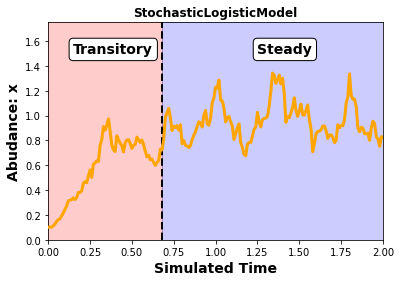

In [104]:
tau=0.1
epsilon=0.01 #set a small epsilon (distance to the asymptote)
t_star = tau*np.log( ( (K-epsilon)/ epsilon ) * (K/abundanceStart-1)  )

#Run simulations
[longitudinal,crossSectional]=StochasticLogisticModel (K,tau,sigmaNoise,muNoise,nSim,timeList,abundanceStart,S)

#########################
#          PLOT         #
#########################

#plot in red the transitory regimen and in blue the stationary one
plt.axvspan(0, t_star, alpha=0.2, color='red',zorder=0)
plt.axvspan(t_star,tEnd, alpha=0.2, color='blue',zorder=0)
#add vertical line in t_star
plt.axvline(x = t_star,color="black",linewidth=2.0,linestyle="--") 

#plot trajectory
plt.plot(timeList,longitudinal,color="orange",linewidth=3,zorder=3) 

plt.xlim(0,2)
plt.ylim(0,1.75)
plt.xlabel("Simulated Time",fontweight='bold',fontsize=14) #add x-label
plt.ylabel("Abudance: x",fontweight='bold',fontsize=14) #add y-label
plt.title("StochasticLogisticModel",fontweight='bold') #set title
plt.text(x=0.15,y=1.5,s="Transitory",fontweight='bold',fontsize=14,bbox=dict(boxstyle="round",ec="black",fc="white"))
plt.text(x=1.25,y=1.5,s="Steady",fontweight='bold',fontsize=14,bbox=dict(boxstyle="round",ec="black",fc="white"))

The time it takes to reach the steady state also depends on the intrinsic growth time $\tau$:

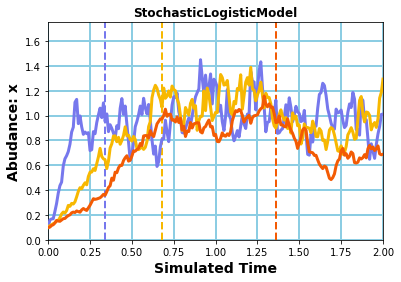

In [105]:
epsilon=0.01 #set a small epsilon (distance to the asymptote)

tau_list=[0.05,0.1,0.2]
color_list=["#7678ed","#f7b801","#f35b04"]

for k,tau in enumerate(tau_list):

    t_star = tau*np.log( ( (K-epsilon)/ epsilon ) * (K/abundanceStart-1)  )

    #Run simulations
    [longitudinal,crossSectional]=StochasticLogisticModel (K,tau,sigmaNoise,muNoise,nSim,timeList,abundanceStart,S)

    #########################
    #          PLOT         #
    #########################

    #add vertical line in t_star
    plt.axvline(x = t_star,color=color_list[k],linewidth=2.0,linestyle="--") 

    #plot trajectory
    plt.plot(timeList,longitudinal,color=color_list[k],linewidth=3,zorder=3) 

    plt.xlim(0,2)
    plt.ylim(0,1.75)
    plt.xlabel("Simulated Time",fontweight='bold',fontsize=14) #add x-label
    plt.ylabel("Abudance: x",fontweight='bold',fontsize=14) #add y-label
    plt.title("StochasticLogisticModel",fontweight='bold') #set title

plt.grid("on",color="#8ccde3",linewidth=2.0,zorder=0) #add a blue grid



## Including species interactions 



### Feasibility and Stability

As before, we create a python function to integrate the model using the Euler-Maruyama method:

In [106]:
def InteractionMatrix_LNDiagonal (S,C,muLN,sigmaLN,muInt,sigmaInt):
    
    """
    Interaction matrix with LogNormal (LN) diagonal and Gaussian off-diagonal fluctuations;
    
    INPUT
    - S (float): species number;
    - C (float): connectance;
    - muLN (float): LN mean of the diagonal elements; 
    - sigmaLN (float): LN widths of the diagonal elements;
    - muInt (float): Gaussian mean of the off-diagonal elements;
    - sigmaInt (float): Gaussian variance of the off-diagonal elements;
    
    OUTPUT
    - M (SxS array): i,j element provides the interaction weight between the species i and j
    """
    
    #interaction
    A = np.random.normal(muInt,sigmaInt,size=(S,S))
    
    #connectance
    boolMat = np.random.uniform(0,1,size=(S,S))
    A = (boolMat<C).astype(int)*A
    A = A-np.diag( np.diag(A) )
    
    #diagonal
    K = 1/np.random.lognormal(muLN,sigmaLN,size=S)
    M = A-np.diag(K)
    
    return(M)

## Environmental filter interaction

### Creating environmental filtering matrix

Diffusion matrix must be symmetric and positive definite. To this aim we can use a Singular Values Decomposition (SVD), which for symmetric matrix reads:

$$ D=U \Lambda U^t $$

where $U$ is a orthogonal matrix $UU^t=\mathbb{1}$ and $\Lambda$ is a diagonal square matrix containing the eigenvalues,which must be all positive for a positive definite matrix. First, the $\Lambda$ matrix can be set at random following a random distribuiton for positive values, for this example I have chose a uniform distribution between $[0,1]$ (you can try other distributions as gamma, beta or lognormal). For the orthogonal matrix $U$, we must draw them from the $O(N)$ Haar distribution, which is already prograed in python in the *ortho_group.rvs* function from the *scipy* library.


Alternatively to function I propose bellow, you can also use the *make_spd_matrix* function from the *sklearn* library, however the random generator for the spectra will be always uniform.

In [107]:
from scipy.stats import ortho_group

def EnvironmentalFilterMatrix(tau,sigmaNoise,S):

        """
        Function to create the correlation noise matrix given a paremeter set
        - tau: dynamics scale;
        - sigmaNoise (float): variance of the Gaussian noise;
        - S: Total number of species
        The correlation noise matrix must be symmetric and positive definite
        """
    
        U=ortho_group.rvs(dim=S)
        L=np.diag(np.random.uniform(low=0,high=1,size=S))
        D=np.matmul(U,np.matmul(L,U.T))
        
        D=D*sigmaNoise/tau
        
        return(D)

### Running simulations

In [108]:
def StochasticLogisticEnviromentalFilter (b,K,tau,sigmaNoise,muNoise,nSim,timeList,abundanceStart,S):
    
    """
    Stochastic Logistic equation with correlated noise (SLM) 
    solution by Euler-Maruyama method;
    
    INPUT
    - b: equivalent correlation Noise Matrix
    - K (float): carrying capacitities;
    - tau (float): intrinsic growth time;
    - sigmaNoise (float): variance of the Gaussian noise;
    - muNoise (float): mean value of the Gaussian noise;
    - nSim (float): number of simulation;
    - timeList (1d array): list of T time instants;
    - abundanceStart (float): initial abundance;
    - S (float): number of species;
    
    OUTPUT
    - longitudinal (T x S array): abundance of the species j at time i;
    - crossSectional (S x nSim array): abundance of the k trajectory at the last time for the j trajectory;
    """
    
    #initial state
    x0 = np.full(S,abundanceStart)

    #simulation loop

    abundanceMat = np.zeros((timeList.size,S,nSim),dtype=float)
    
    dt = round((timeList[-1]-timeList[0])/(len(timeList)),2)
    
    for sim in range(nSim):
        
        abundanceMat[0,:,sim] = x0
        
        #time loop
        for t in range(1,timeList.size):

            #dynamics
            x = abundanceMat[t-1,:,sim]
            z=np.random.normal(0,1,size=(S))
            noise = muNoise+np.matmul(b,z)
            xt = x+x*dt/tau-x**2/(tau*K)*dt+mt.sqrt(dt)*(noise*x) #equation
        
            abundanceMat[t,:,sim]=np.round(xt,5)
    
    longitudinal = abundanceMat[:,:,0]
    crossSectional = abundanceMat[-1,:,:]
    
    return([longitudinal,crossSectional])